

<center><table>
<tr>

<th> <img src= "INL1.png",align="middle",style="width: 10000px;"/> </th>
</tr>
<tr>
<th> <img src="PennNucDataCenter.jpeg"  ,align="middle", style="width: 500px;"/> </th>
</tr>
<center><table>

# <center>Nuclear-Powered Data Centers Economic Optimization Strategy</center>

#### Expected Outcome
- A journal paper evaluating <u>the economic threshold points</u> identifying the conditions under which user requirements would be better suited by a large, small, or micro-reactor. The use case will be focused on data centers and will provide INL with the credential to stake a claim as a leader in nuclear for data center research.

- With a framework on hand, the lab could then leverage its expertise to offer advisory support for the various data centers considering nuclear energy. Further, with interest growing in this area, it is possible that DOE-NE would sponsor research on coupling nuclear reactors with data centers. INL would be well positioned to lead such R&D activities.

#### Activity
- A framework is proposed to evaluate the **economic tradeoff** between large, small, and micro-reactors. 
- The intent is to map out ‘threshold values’ under a given set of requirements 
  - energy demand size
  - reliability 
  
- The framework would parametrize a set of important economic variables to quantifiably differentiate the different reactor classes. 
  - nuclear capacity
  - diseconomies of scale, 
   - economies of mass production, 
   - speed of deployment, 
   - downtime intervals  



### Required Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


/tmp/ipykernel_2431476/322873457.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### The Overnight costs of Large reactors vs SMR vs Micro-reactors
- Instead of estimating the actual costs of SMRs and MRs in USD, the costs are estimated relative to the cost of the large reactors because
  - The cost estimates of the nuclear projects are highly uncertain.
  - The goal of evaluating the economic tradeoffs between the large, small and micro reactors

<br>

### Relative Costs of SMR and Micro-reactors (Method #1)
- From a literature review (Abou Jaoude 2023), the costs of large reactor ranges between 2,557 and 8,098 $/kWe
- SMR costs range between 4,077 and 13,001 $/kWe
- Microreactos costs range beteween 3,996 and 72,611 $/kWe

<br>

- Therefore, the SMRs cost relative to Large reactors ranges between 0.5 and 5 ($/kWe)
- Therefore, the Microreactors' cost relative to Large reactors ranges between 0.5 and 28.4 ($/kWe)

<br>

### Relative Costs of SMR and Micro-reactors (Method #2)
- From Moore 2016, 

$$
\frac{OCC_{Small Reactor} (USD)}{OCC_{Large Reactor} (USD)} = (\frac{Power_{Small Reactor} }{Power_{Large Reactor} })^n
$$

Where n ranges between 0.4 and 0.7 

- Calculating the levelized capital cost (USD/kWe): 
$$
\frac{OCC_{Small Reactor} (USD/kWe)}{OCC_{Large Reactor} (USD/kWs)} = (\frac{Power_{Small Reactor} }{Power_{Large Reactor} })^{n-1} 
$$
- Therefore, the SMR (300MWe) cost relative to a Large reactor (1000MWe) ranges between 1.4 and 2.1 ($/kWe)
- The SMR (50MWe) cost relative to a Large reactor (1000MWe) ranges between 2.5 and 6 ($/kWe)
- The Microreactor (20MWe) cost relative to a Large reactor (1000MWe) ranges between  3.2 and 10.5 ($/kWe)
- The Microreactor (1MWe) cost relative to a Large reactor (1000MWe) ranges between  7.9 and 63.1 ($/kWe)


### FOAK vs Fleet-Avg Cost
- A few or several or dozens or reactors have to be build to meet the electricity demand. The cost is expected to go down when building more units, due to the learning rate.
- The fleet-avg cost relative to the FOAK cost is:
$$
 \frac{OCC_{Fleet-avg}}{OCC_{FOAK}} =\frac{\sum_{i=1}^N (1-LR) ^{log{_2}{n_i}}}{N}
 $$

$LR$ is the learning rate, $n_i$ refers to the first, second, third, ...$i_{th}$ of a kind unit,  $N$ is the total number of units built

$$
N = \frac{Total Power Demand}{Reactor Power}
$$



## User inputs

In [2]:
SR_to_Large_min=  0.5
SR_to_Large_max = 28

# Micro_to_Large_min = 0.5
# Micro_to_Large_max = 28.4

# Power Ranges for eac reactor (MW)
SR_P0 = 1 
SR_P1 = 300

# # Microreactors power ranges
# m_P0 = 1
# m_P1 = 50

#Baseline learning rate and power demand
LR_0 = 0.15
Tot_Power_Demand_0 = 1500  #MWe

# Learning rate range
LR = np.linspace(0, 0.3, 30)
LR_window = abs(LR[0] - LR[1])


print( f"The Learning rate ranges between  {min(LR)}  and  {max(LR)}" )


The Learning rate ranges between  0.0  and  0.3


## What is the tipping point for the small reactors?

In [3]:
counter = 0

#save data
LR_list = []
power_list = []
initial_cost_SR_list = []
SR_reduced_cost_list = []


for P in  np.linspace(SR_P0 , SR_P1 , 1+int(SR_P1 - SR_P0)) :# between 50 and 300 MW for one SR 
    # number of SR required to get to the target 1500MW
    num =int( np.ceil(Tot_Power_Demand_0 /P))  # it has to be the ceiling

    for lr in LR: # iterate through learning rate
        cost_reduction_factor = 0 # initizalition
        
        for nn in range(1, num +1):# cost decreases from NOAK to FOAK and averaged over the number of reactors built
            cost_reduction_factor += ( (1 - lr) **(np.log2(nn)))/num
            
        
         #cost of each reactor
        num_cost_values = int((SR_to_Large_max - SR_to_Large_min)/0.05) # how many values between min and max cost
        
        for n in range(num_cost_values+1): # 
            SR_cost = SR_to_Large_min + ((n)/num_cost_values)*((SR_to_Large_max - SR_to_Large_min))    
            
            # cost reduction due to Learning rate
            SR_reduced_cost =   SR_cost *  cost_reduction_factor   
            
            counter = counter +1
            
            LR_list.append(lr)
            power_list.append(P)
            initial_cost_SR_list.append(SR_cost)
            SR_reduced_cost_list.append(SR_reduced_cost)
            
SR_FOAK_cost_window = abs(initial_cost_SR_list[0] - initial_cost_SR_list[1])
SR_reduced_cost_window  = abs (SR_reduced_cost_list[50] -SR_reduced_cost_list[51])



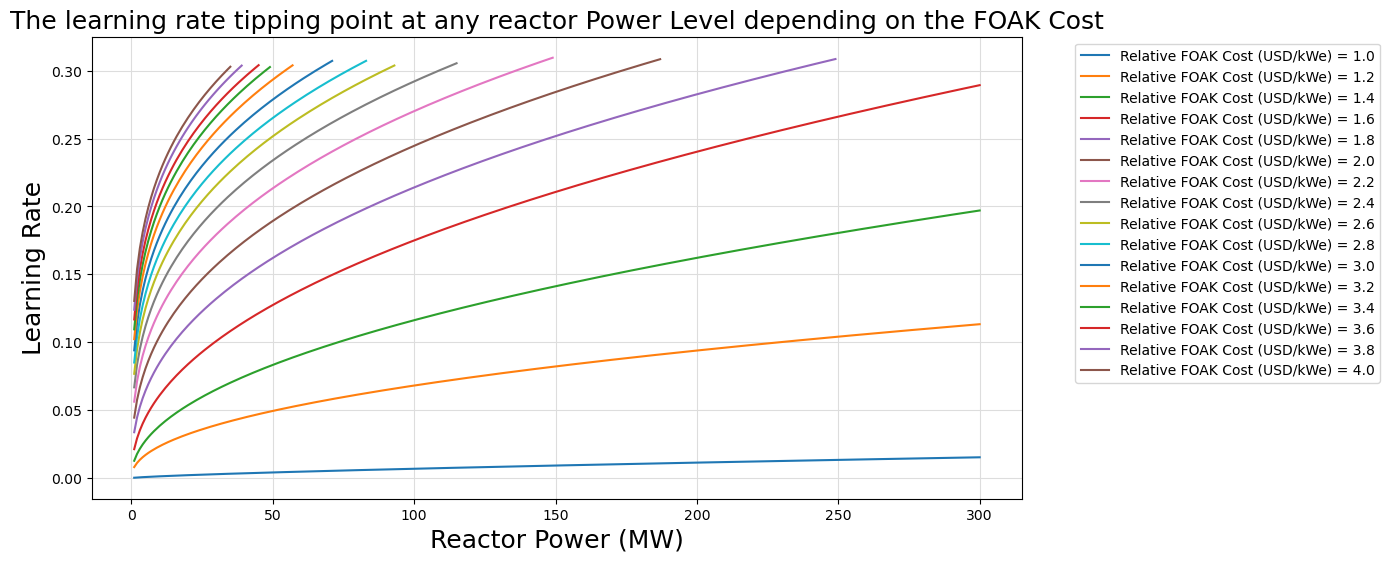

In [4]:
# we are interested in the reduced cost which is around 1 or less than 1
full_results = np.vstack((np.array(power_list), np.array(LR_list) ,np.array(initial_cost_SR_list), np.array(SR_reduced_cost_list)))
full_results = full_results.T  


# When the cost is less than 1 and larger than 0.99
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
for FOAK_cost in np.linspace(1, 4, 16):
    try:
        cost_list = []
        for n in range(full_results.shape[0]):
            row = full_results[n]
            cost = row[-1]
            
            initial_cost = row[-2]
       
            if abs(cost - 1) < SR_reduced_cost_window :
                
                if abs(FOAK_cost - initial_cost) < SR_FOAK_cost_window:
                    cost_list.append(row)
        cost_array = (np.vstack(cost_list))
       
        # p = ax.scatter( cost_array [:, 0],cost_array [:, 1])
        x = cost_array [:, 0]
        y = cost_array [:, 1]
        popt, pcov = curve_fit(lambda fx,a,b: a*fx**-b,  x,  y)
        power_y = popt[0]*x**-popt[1]
        plt.plot(x, power_y ,label = f"Relative FOAK Cost (USD/kWe) = {np.round(FOAK_cost,1)}")
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')





    except:
        ...


# Show the major grid and style it slightly.
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('Reactor Power (MW)', fontsize=18) 
plt.ylabel('Learning Rate', fontsize=18)  
plt.title('The learning rate tipping point at any reactor Power Level depending on the FOAK Cost', fontsize=18) 
plt.show()

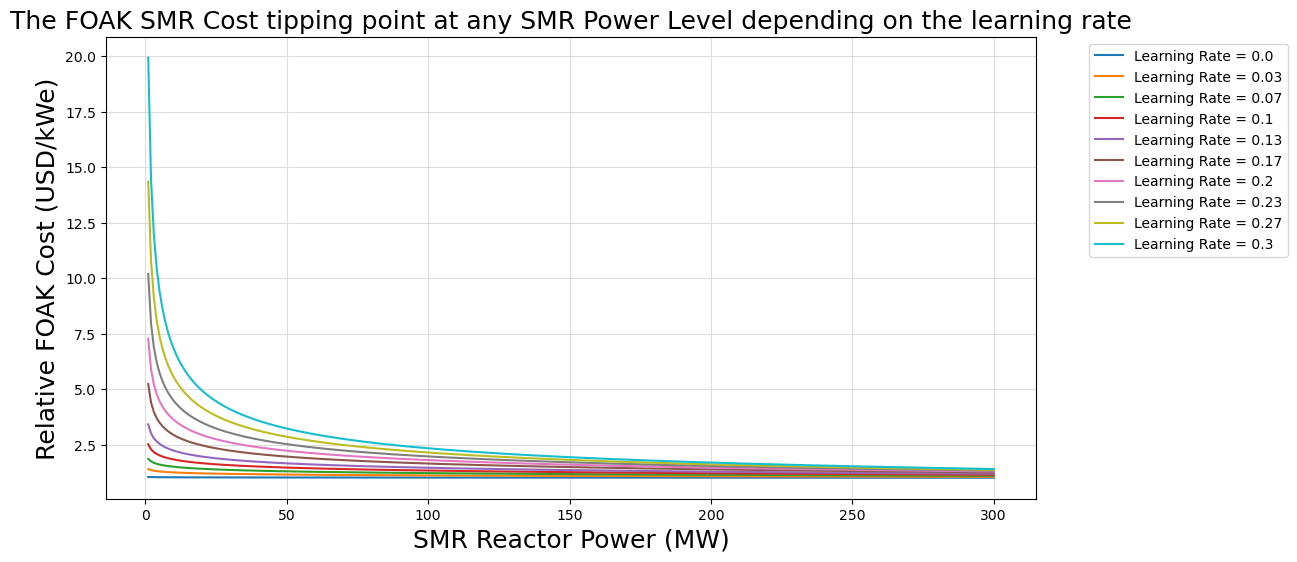

In [5]:
#    x = power, y = cost , z =learning rate
   # When the cost  less than 1 and larger than 0.99
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
for lr in np.linspace(0, 0.3, 10):
  
    try:
        cost_list = []
        for n in range(full_results.shape[0]):
            row = full_results[n]
            cost = row[-1]
            learning = row[-3]
            if abs(cost - 1) <=SR_reduced_cost_window :
                
                
                if abs( learning  - lr) < 0.02 :
                    
                    cost_list.append(row)
        cost_array = (np.vstack(cost_list))

        # p = ax.scatter( cost_array [:, 0],cost_array [:, 1])
        x = cost_array [:, 0]
        y = cost_array [:, 2]
        popt, pcov = curve_fit(lambda fx,a,b: a*fx**-b,  x,  y)
        power_y = popt[0]*x**-popt[1]
        plt.plot(x, power_y ,label = f"Learning Rate = {np.round(lr,2)}")
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')





    except:
        ...

# Show the major grid and style it slightly.
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
# # Show the minor grid as well. Style it in very light gray as a thin,
# # dotted line.
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('SMR Reactor Power (MW)', fontsize=18) 
plt.ylabel('Relative FOAK Cost (USD/kWe)', fontsize=18)  
plt.title('The FOAK SMR Cost tipping point at any SMR Power Level depending on the learning rate', fontsize=18)    
plt.show()     


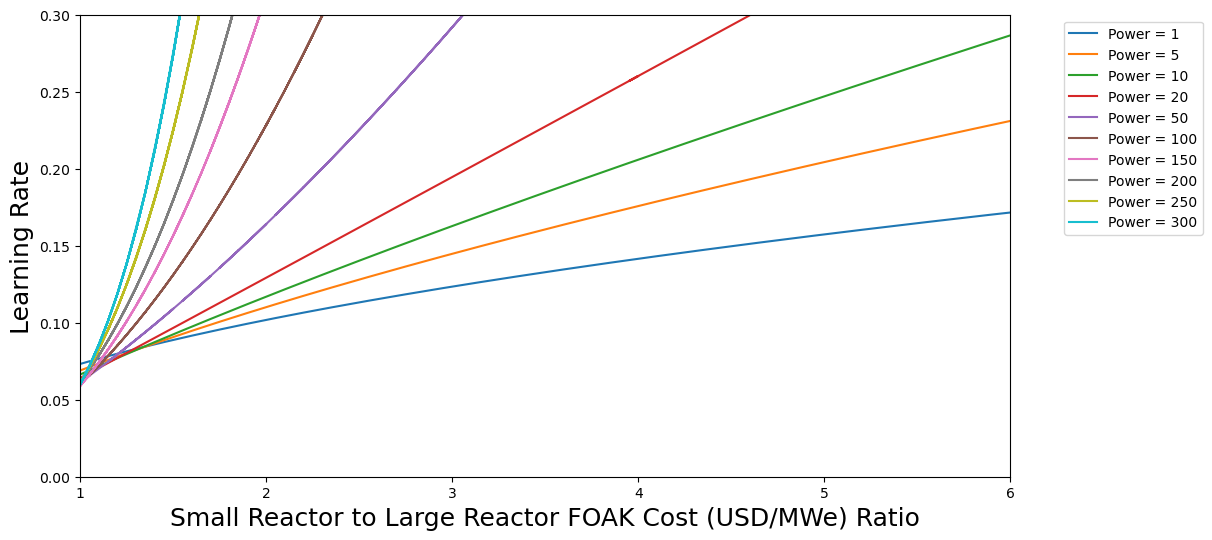

In [6]:
fig = plt.figure(figsize=(12, 6))


for PP in [1, 5, 10, 20, 50, 100, 150, 200, 250, 300]:
    
  
    try:
        cost_list = []
        for n in range(full_results.shape[0]):
            row1 = full_results[n]
            cost = row1[-1]
            power1 = row1[0]
            
            if abs(cost - 1) <   SR_reduced_cost_window :
                
                
                if abs( power1 - PP) < 1 :
                    
                    cost_list.append(row1)
        cost_array = (np.vstack(cost_list))

        x = cost_array [:, 2]
        y = cost_array [:, 1]
        
        popt, pcov = curve_fit(lambda fx,a,b: a*fx**-b,  x,  y)
        x_range = np.linspace(1, 8, 200)
        power_y = popt[0]*x**-popt[1]
        
        plt.plot(x, power_y ,label = f"Power = {int(PP)}")
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')





    except:
        ...

# Show the major grid and style it slightly.
# plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
# # # Show the minor grid as well. Style it in very light gray as a thin,
# # # dotted line.
# plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('Small Reactor to Large Reactor FOAK Cost (USD/MWe) Ratio', fontsize=18) 
plt.ylabel('Learning Rate', fontsize=18)  
plt.ylim(0, 0.3)
plt.xlim(1, 6)
# plt.title('The FOAK SMR Cost tipping point at any SMR Power Level depending on the learning rate', fontsize=18)    
plt.show()    

## What is the tipping point for the Microreactors

In [7]:
# counter = 0

# #save data
# LR_list = []
# power_list = []
# initial_cost_MR_list = []
# MR_reduced_cost_list = []


# for P in  np.linspace(m_P0, m_P1, 100) :# MR Power
    
#     # number of MRs required to get to the target 1500MW
#     num =int( np.ceil(Tot_Power_Demand_0 /P))  # it has to be the ceiling

#     for lr in LR: # iterate through learning rate
#         cost_reduction_factor = 0 # initizalition
#         for nn in range(1, num +1):# cost decreases from NOAK to FOAK and averaged over the number of reactors built
#             cost_reduction_factor += ( (1 - lr) **(np.log2(nn)))/num
            
        
#          #cost of each reactor
#         for n in range(100): # 100 values between min and max cost
#             MR_cost = Micro_to_Large_min + ((n+1)/100)*((Micro_to_Large_max - Micro_to_Large_min))    
        
#             # cost reduction due to Learning rate
#             MR_reduced_cost =   MR_cost *  cost_reduction_factor   
            
#             counter = counter +1
            
#             LR_list.append(lr)
#             power_list.append(P)
#             initial_cost_MR_list.append(MR_cost)
#             MR_reduced_cost_list.append(MR_reduced_cost)
            
# MR_FOAK_cost_window = abs(initial_cost_MR_list[0] - initial_cost_MR_list[1])


# # we are interested in the reduced cost which is around 1 or less than 1
# full_results = np.vstack((np.array(power_list), np.array(LR_list) ,np.array(initial_cost_MR_list), np.array(MR_reduced_cost_list)))
# full_results = full_results.T 


In [8]:

#  # When the cost is less than 1 and larger than 0.99
# fig = plt.figure(figsize=(12, 6))
# ax = fig.add_subplot()

# for FOAK_cost in np.linspace(1, 27, 14):
    
#     try:
#         cost_list = []
#         for n in range(full_results.shape[0]):
#             row = full_results[n]
#             cost = row[-1]
#             initial_cost = row[-2]
#             if abs(cost - 1) <=0.05:
                
#                 if abs(FOAK_cost - initial_cost) < 0.3:
#                     cost_list.append(row)
#         cost_array = (np.vstack(cost_list))
       
#         # p = ax.scatter( cost_array [:, 0],cost_array [:, 1])
#         x = cost_array [:, 0]
#         y = cost_array [:, 1]
#         popt, pcov = curve_fit(lambda fx,a,b: a*fx**-b,  x,  y)
#         power_y = popt[0]*x**-popt[1]
#         plt.plot(x, power_y ,label = f"Relative FOAK Cost (USD/kWe) = {np.round(FOAK_cost,1)}")
#         plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')





#     except:
#         ...


# # # Show the major grid and style it slightly.
# plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
# # # Show the minor grid as well. Style it in very light gray as a thin,
# # # dotted line.
# plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
# plt.xlabel('Micro Reactor Power (MW)', fontsize=18) 
# plt.ylabel('Learning Rate', fontsize=18)  
# plt.title('The learning rate tipping point vs. Microreactor Power depending on the Microreactor FOAK Cost', fontsize=18) 
# plt.show()



In [9]:

# #    x = power, y = cost , z =learning rate
#    # When the cost  less than 1 and larger than 0.99
# fig = plt.figure(figsize=(12, 6))
# ax = fig.add_subplot()
# for lr in np.linspace(0, 0.3, 10):
  
#     try:
#         cost_list = []
#         for n in range(full_results.shape[0]):
#             row = full_results[n]
#             cost = row[-1]
#             learning = row[-3]
#             if abs(cost - 1) <=0.05:
                
                
#                 if abs( learning  - lr) < LR_window :
                    
#                     cost_list.append(row)
#         cost_array = (np.vstack(cost_list))

#         # p = ax.scatter( cost_array [:, 0],cost_array [:, 1])
#         x = cost_array [:, 0]
#         y = cost_array [:, 2]
#         popt, pcov = curve_fit(lambda fx,a,b: a*fx**-b,  x,  y)
#         power_y = popt[0]*x**-popt[1]
#         plt.plot(x, power_y ,label = f"Learning Rate = {np.round(lr,2)}")
#         plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')





#     except:
#         ...

# # # Show the major grid and style it slightly.
# plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
# # # # Show the minor grid as well. Style it in very light gray as a thin,
# # # # dotted line.
# plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
# plt.xlabel('MicroReactor Power (MW)', fontsize=18) 
# plt.ylabel('Relative FOAK Cost (USD/kWe)', fontsize=18)  
# plt.title('The FOAK Microreactor Cost tipping point vs. Microreactor Power depending on the learning rate', fontsize=18)    
# # plt.show()  
  


# What if the learning rate is fixed (known) and the total power demand is changing ?

In [10]:
# counter = 0

# #save data
# demand_list = []
# power_list = []
# initial_cost_SMR_list = []
# SMR_reduced_cost_list = []


# for P in  np.linspace(SMR_P0 , SMR_P1 , 100) :# between 50 and 300 MW for one SMR 
#     for demand in np.linspace(1000 , 2000 , 11):
    
#         # number of SMR required to get to the target 
#         num =int( np.ceil(demand /P))  # it has to be the ceiling
            
#             # Learning rate
#         cost_reduction_factor = 0 # initizalition    
#         for nn in range(1, num +1):# cost decreases from NOAK to FOAK and averaged over the number of reactors built
#             cost_reduction_factor += ( (1 - LR_0) **(np.log2(nn)))/num
                
            
#             #cost of each reactor
#         for n in range(100): # 100 values between min and max cost
#             SMR_cost = SMR_to_Large_min + ((n+1)/100)*((SMR_to_Large_max - SMR_to_Large_min))    
        
#             # cost reduction due to Learning rate
#             SMR_reduced_cost =   SMR_cost *  cost_reduction_factor   
            
#             counter = counter +1
            
#             power_list.append(P)
#             demand_list.append(demand)
#             initial_cost_SMR_list.append(SMR_cost)
#             SMR_reduced_cost_list.append(SMR_reduced_cost)
            
# SMR_FOAK_cost_window = abs(initial_cost_SMR_list[0] - initial_cost_SMR_list[1])

# full_results = np.vstack((np.array(power_list), np.array(demand_list) ,np.array(initial_cost_SMR_list), np.array(SMR_reduced_cost_list)))
# full_results = full_results.T  



## What is the tipping point for the SMR?

In [11]:
# # we are interested in the reduced cost which is around 1 or less than 1



# # # When the cost is less than 1 and larger than 0.99
# fig = plt.figure(figsize=(12, 6))
# ax = fig.add_subplot()
# for FOAK_cost in np.linspace(1, 4, 16):
#     try:
#         cost_list = []
#         for n in range(full_results.shape[0]):
#             row = full_results[n]
#             # print(row)
#             cost = row[-1]
            
#             initial_cost = row[-2]
#             if abs(cost - 1) <=0.1:
#                 # print((FOAK_cost, initial_cost))
                
#                 if abs(FOAK_cost - initial_cost) < 0.1:
                    
#                     cost_list.append(row)
#         cost_array = (np.vstack(cost_list))
       
#         # p = ax.scatter( cost_array [:, 0],cost_array [:, 1])
#         x = cost_array [:, 0]
#         y = cost_array [:, 1]
#         popt, pcov = curve_fit(lambda fx,a,b: a*fx**-b,  x,  y)
#         power_y = popt[0]*x**-popt[1]
#         plt.plot(x, power_y ,label = f"Relative FOAK Cost (USD/kWe) = {np.round(FOAK_cost,1)}")
#         plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')





#     except:
#         ...


# # # # Show the major grid and style it slightly.
# # plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
# # # # Show the minor grid as well. Style it in very light gray as a thin,
# # # # dotted line.
# # plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
# # plt.xlabel('SMR Reactor Power (MW)', fontsize=18) 
# # plt.ylabel('Demand (MW)', fontsize=18)  
# # plt.title('The demand tipping point at any SMR Power Level depending on the SMR FOAK Cost', fontsize=18) 
# plt.show()